In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import scipy.io as sc
from glob import glob
import keras
from keras import layers

In [11]:
!unzip with_mask.zip;
!unzip without_mask.zip;

 inflating: without mask/341.jpg    
  inflating: without mask/augmented_image_48.jpg  
  inflating: without mask/augmented_image_254.jpg  
  inflating: without mask/augmented_image_55.jpg  
  inflating: without mask/augmented_image_107.jpg  
  inflating: without mask/augmented_image_121.jpg  
  inflating: without mask/augmented_image_293.jpg  
  inflating: without mask/454.jpg    
  inflating: without mask/478.jpg    
  inflating: without mask/augmented_image_57.jpg  
  inflating: without mask/258.jpg    
  inflating: without mask/158.jpg    
  inflating: without mask/220.jpg    
  inflating: without mask/augmented_image_95.jpg  
  inflating: without mask/163.jpg    
  inflating: without mask/177.jpg    
  inflating: without mask/augmented_image_306.jpg  
  inflating: without mask/98.jpg     
  inflating: without mask/344.jpg    
  inflating: without mask/225.jpg    
  inflating: without mask/309.jpg    
  inflating: without mask/augmented_image_219.jpg  
  inflating: without mask/aug

In [12]:
!mkdir train;
!mv with_mask train;
!mv without_mask train;

mkdir: cannot create directory â€˜trainâ€™: File exists


### Set Up Data

In [23]:
from sklearn.model_selection import train_test_split
with_mask = glob('train/with_mask/*.jpg')
without_mask = glob('train/without_mask/*.jpg')
with_mask_train, with_mask_test = train_test_split(with_mask, test_size=0.1)
without_mask_train, without_mask_test = train_test_split(without_mask, test_size=0.1)


#moves the validation files out of the train directory and over to the val directory.

!mkdir val

!mkdir val/with_mask
files = ' '.join(with_mask_test)
!mv $files val/with_mask 

!mkdir val/without_mask
files = ' '.join(without_mask_test)
!mv $files val/without_mask

!rm -rf train/.ipynb_checkpoints
!rm -rf val/.ipynb_checkpoints


mkdir: cannot create directory â€˜valâ€™: File exists
mkdir: cannot create directory â€˜val/with_maskâ€™: File exists
mkdir: cannot create directory â€˜val/without_maskâ€™: File exists


Found 1113 files belonging to 2 classes.
Found 263 files belonging to 2 classes.


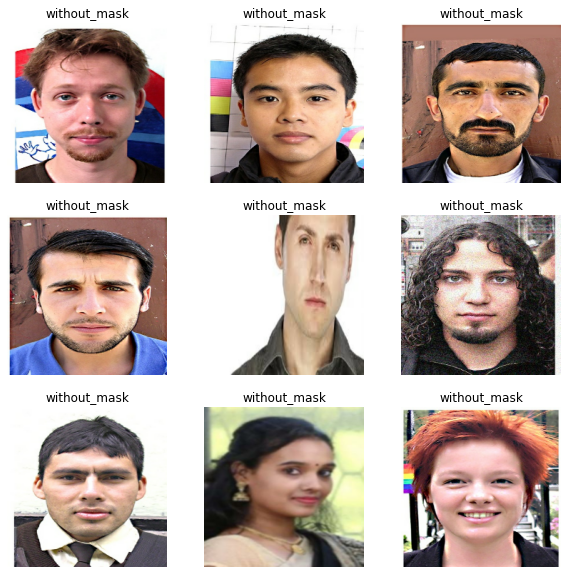

In [24]:
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = image_dataset_from_directory('./train', #sets up training dataset
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory('./val', #sets up validation dataset
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10)) 
for images, labels in train_dataset.take(1): #shows 9 examples of the training dataset
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Augment data for training

In [25]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator( #allow for rotation, zooming, and flipping of training images 
    rescale = 1./255.,
    rotation_range=90,
    zoom_range=[1,2],
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(#### 
    rescale = 1./255.,
#     rotation_range=90,
#     zoom_range=[1,2],
#     horizontal_flip=True,
#     fill_mode='nearest' 
)

train_generator = train_datagen.flow_from_directory(
    './train',
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    class_mode='categorical')
    
validation_generator = validation_datagen.flow_from_directory(
    './val',
    target_size=(224,224),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 1113 images belonging to 2 classes.
Found 263 images belonging to 2 classes.


### Configure dataset for performance

In [26]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE

# train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
# validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

### Modify network

In [27]:
model = keras.applications.MobileNetV2() #pre-trained, 14MB, smallest available model
model.summary()

ise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 14, 14, 192)  0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 14, 14, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 14, 14, 64)   256         block_6_project[0][0]            
__________________________________________________________________________________________________
block_7_expand (Conv2D)         (None, 14, 14, 384)  24576       block_6_project_BN[0][0]         
__________________________________________________________________________________________________
block_7_expand_BN (BatchNormali (None, 14, 14, 384)  1536        block_7_expand[0][0]    

In [28]:
#creates base model from pretrained network trained on ImageNet dataset
#Here by setting include_top to false we exclude the classification layers at the end of the network
base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
base_model.summary()

_relu[0][0]        
__________________________________________________________________________________________________
block_6_depthwise (DepthwiseCon (None, 14, 14, 192)  1728        block_6_pad[0][0]                
__________________________________________________________________________________________________
block_6_depthwise_BN (BatchNorm (None, 14, 14, 192)  768         block_6_depthwise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 14, 14, 192)  0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 14, 14, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 14, 14, 64)   256         block_6_project[0][0]   

In [29]:
from keras import Model
base_model.trainable = False #freeze the base weights, model has already learned these

# # Flatten the output layer to 1 dimension
# x = layers.Flatten()(base_model.output)

# # Add a fully connected layer with 512 hidden units and ReLU activation
# x = layers.Dense(512, activation='relu')(x)

# # Add a dropout rate of 0.5
# x = layers.Dropout(0.5)(x)

# # Add a final sigmoid layer for classification
# x = layers.Dense(2, activation='sigmoid')(x)

# new_model = tf.keras.models.Model(base_model.input, x)

flat_layer = keras.layers.Flatten()(base_model.output)
dense_layer = keras.layers.Dense(2, activation='sigmoid')(flat_layer) #binary output
final_output = layers.Activation('sigmoid')(dense_layer)
new_model = keras.Model(inputs = base_model.input, outputs = final_output)

In [30]:
new_model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

In [31]:
# EPOCHS = 5
# BATCH_SIZE = 10
# STEPS_PER_EPOCH = 5
# VALIDATION_STEPS = 1
EPOCHS = 8
BATCH_SIZE = 11
STEPS_PER_EPOCH = 5
VALIDATION_STEPS = 1
# MODEL_FILE = 'filename.model'

# history = new_model.fit(
#     train_generator,
#     epochs=EPOCHS,
#     steps_per_epoch=STEPS_PER_EPOCH,
#     validation_data=validation_generator,
#     validation_steps=VALIDATION_STEPS)

MODEL_FILE = 'maskdetector.model'

hist = new_model.fit(train_generator, validation_data = validation_generator, validation_steps=1, steps_per_epoch = 5, epochs = 15)
# hist = model.fit(train_generator,epochs=5,validation_data=validation_generator)
new_model.save(MODEL_FILE)

Epoch 1/15
5/5 [==============================] - 13s 3s/step - loss: 0.6760 - acc: 0.6313 - val_loss: 0.5531 - val_acc: 0.9688
Epoch 2/15
5/5 [==============================] - 12s 2s/step - loss: 0.5790 - acc: 0.9062 - val_loss: 0.5179 - val_acc: 1.0000
Epoch 3/15
5/5 [==============================] - 12s 2s/step - loss: 0.5510 - acc: 0.9375 - val_loss: 0.5334 - val_acc: 0.9375
Epoch 4/15
5/5 [==============================] - 12s 2s/step - loss: 0.5384 - acc: 0.9688 - val_loss: 0.5371 - val_acc: 0.9688
Epoch 5/15
5/5 [==============================] - 12s 2s/step - loss: 0.5306 - acc: 0.9625 - val_loss: 0.5086 - val_acc: 1.0000
Epoch 6/15
5/5 [==============================] - 11s 2s/step - loss: 0.5292 - acc: 0.9688 - val_loss: 0.5065 - val_acc: 1.0000
Epoch 7/15
5/5 [==============================] - 12s 2s/step - loss: 0.5191 - acc: 0.9875 - val_loss: 0.5257 - val_acc: 0.9375
Epoch 8/15
5/5 [==============================] - 18s 4s/step - loss: 0.5337 - acc: 0.9500 - val_loss: 0

In [32]:
from keras.preprocessing import image
from keras.models import load_model
from keras.applications.mobilenet_v2 import preprocess_input

def predict(model, img):
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

# We plot the original image
plt.figure()
img = image.load_img('./testWith/test3.jpg', target_size=(224, 224))
preds = predict(load_model(MODEL_FILE), img)
print(preds)
plt.imshow(img)

# We can visualize the predicted likelihood of each class
plt.figure()
labels = ["with_mask", "without_mask"]
plt.barh(range(2),preds,alpha=0.5)
plt.yticks(range(2),labels)
plt.xlabel('Probability')
plt.xlim(0,1)
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: './testWith/test3.jpg'

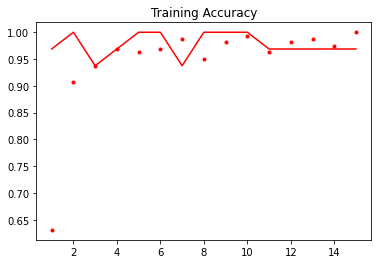

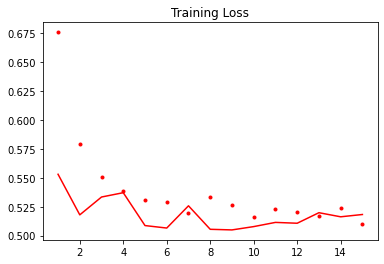

In [36]:
import matplotlib.pyplot as plt
acc = hist.history['acc']
loss = hist.history['loss']
val_acc = hist.history['val_acc']
val_loss = hist.history['val_loss']
epochs = range(1,len(acc)+1)

plt.plot(epochs, val_acc,'r')
plt.plot(epochs, acc,'r.')
plt.title("Training Accuracy")

plt.figure()
plt.plot(epochs, val_loss,'r')
plt.plot(epochs,loss,'r.')
plt.title("Training Loss")
plt.show()